In [1]:
#!/usr/bin/env python
import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

__author__ = "Malthe Faurschou Tøttrup"
__email__ = "malthe@toettrup.dk"

is_done = False


# Load the gym environment
env = gym.make('Snake-8x8-v0')

def resetEnv():
    global is_done

    is_done = False
    env.reset()

resetEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

register(
    id='Snake--4x4-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__4x4_DeadApple_'
)
register(
    id='Snake-Hex-4x4-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_4x4_DeadApple_'
)
register(
    id='Snake--8x8-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__8x8_DeadApple_'
)
register(
    id='Snake-Hex-8x8-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_8x8_DeadApple_'
)
register(
    id='Snake--16x16-DeadApple--v0',
    entry_point='gym_snake.envs:Snake__16x16_DeadApple_'
)
register(
    id='Snake-Hex-16x16-DeadApple--v0',
    entry_point='gym_snake.envs:Snake_Hex_16x16_DeadApple_'
)
register(
    id='Snake--4x4---v0',
    entry_point='gym_snake.envs:Snake__4x4__'
)
register(
    id='Snake-Hex-4x4---v0',
    entry_point='gym_snake.envs:Snake_Hex_4x4__'
)
register(
    id='Snake--8x8---v0',
    entry_point='gym_snake.envs:Snake__8x8__'
)
register(
    id='Snake-Hex-8x8---v0',
    entry_point='gym_snake.envs:Snake_Hex_8x8__'
)
register(
    

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [2]:
#Reward shaping


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(16, interpolation=Image.BOX),
                    T.ToTensor()])

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW) #TODO: CHANGE
    return resize(screen).unsqueeze(0)


/home/malthet/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [5]:
class DQL_CNN(nn.Module):
    
    def __init__(self, outputs):
        super(DQL_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1024, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = self.bn1(x)
        x = self.fc1(x.view(x.size(0), -1))
        return x
    

""" Deep Minds architecture for reference """
class DQL_DeepMind(nn.Module):
        
    def __init__(self, outputs):
        super(DQL_DeepMind, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, padding='valid', stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding='valid', stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding='valid', stride=1)
        self.fc1 = nn.Linear(1024, outputs) #origninally 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.fc1(x.view(x.size(0), -1))
        return x

In [6]:
""" Hyperparameters """
BATCH_SIZE = 128
GAMMA = 0.95

exploration_rate = 1.
exploration_decay = 0.99997
exploration_min = 0.1

TARGET_UPDATE = 1000
learning_rate = 1e-4  
decay_rate = 0.99 
num_episodes = 10000
MEMORY_SIZE = 10000

In [7]:
""" Network initialization """



# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
# screen_height, screen_width, _ = screen = env.render(mode='rgb_array').shape 

# Get number of actions from gym action space
n_actions = env.action_space.n

""" Initialize policy net and target net """
policy_net = DQL_CNN(n_actions).to(device)
target_net = DQL_CNN(n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

""" Optimizer """
#ref: https://ai.stackexchange.com/questions/9298/neural-network-optimizers-in-reinforcement-learning-non-well-behaved-environment
#ref: https://stackoverflow.com/questions/59833217/best-reinforcement-learner-optimizer
#optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate, weight_decay=decay_rate) 
#optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.Adam(policy_net.parameters())
#optimizer = optim.SGD(policy_net.parameters())


""" Loss function """
#criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
criterion = nn.SmoothL1Loss()
#criterion = nn.MSELoss()

""" Initialize experince memory """
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0

def select_action(state):
    global steps_done
    global exploration_rate
    exploration_rate *= exploration_decay
    exploration_rate = max(exploration_rate, exploration_min)
    steps_done += 1
    if np.random.rand() > exploration_rate:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [8]:
""" Model Optimization """

losses = []
mean_loss = []
def optimize_model():
        
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
                                          
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    #print(expected_state_action_values.unsqueeze(1))
    #print(state_action_values)
    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    losses.append(loss.to('cpu').detach().numpy())
    mean_loss.append(np.mean(losses))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



In [9]:
""" Training """
num_model = "CNN1"
save_path = 'models/snakeai'+str(num_model)+'.pkl'

episode_reward = 0
rewards = []
moveing_average_rewards = []

for i_episode in range(num_episodes):

    episode_reward = 0

    if i_episode % 100 == 0 and i_episode != 0:
        print("playing episode: ", i_episode,"/",num_episodes, 
        " mean loss => ", round(mean_loss[-1],4),
        "mean reward => ", round(moveing_average_rewards[-1], 4))

    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen + last_screen


    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device).long()
        episode_reward += reward

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen + last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        if done:
            rewards.append(episode_reward.item())
            # Take the mean of the last 100 rewards
            moveing_average_rewards.append(np.mean(rewards[-100:]))
            break

        # Update the target network, copying all weights and biases in DQN
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            torch.save(policy_net.state_dict(), save_path)

print('Complete')
env.close()
plt.plot(rewards)
plt.plot(moveing_average_rewards)
plt.ioff()
plt.show()

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


playing episode:  100 / 10000  mean loss =>  27.5809 mean reward =>  -0.93
playing episode:  200 / 10000  mean loss =>  14.1348 mean reward =>  -0.92
playing episode:  300 / 10000  mean loss =>  9.6803 mean reward =>  -0.92
playing episode:  400 / 10000  mean loss =>  7.4043 mean reward =>  -0.96
playing episode:  500 / 10000  mean loss =>  6.2463 mean reward =>  -0.9
playing episode:  600 / 10000  mean loss =>  6.108 mean reward =>  -0.92
playing episode:  700 / 10000  mean loss =>  5.7343 mean reward =>  -0.96
playing episode:  800 / 10000  mean loss =>  5.2276 mean reward =>  -0.89
playing episode:  900 / 10000  mean loss =>  4.7121 mean reward =>  -0.91
playing episode:  1000 / 10000  mean loss =>  4.39 mean reward =>  -0.91
playing episode:  1100 / 10000  mean loss =>  4.056 mean reward =>  -0.82
playing episode:  1200 / 10000  mean loss =>  3.7962 mean reward =>  -0.94
playing episode:  1300 / 10000  mean loss =>  3.5636 mean reward =>  -0.9
playing episode:  1400 / 10000  mean l

KeyboardInterrupt: 

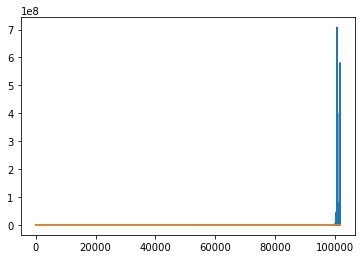

In [10]:
plt.plot(losses[-len(losses)+1000:])
plt.plot(mean_loss[-len(mean_loss)+1000:])

In [11]:
""" Record 10 videos """

training = False
env = gym.wrappers.RecordVideo(env, 'video/CNN', episode_trigger = lambda x: x % 100 == 0)


if(not training):

    num_episodes = 10

    env = gym.wrappers.RecordVideo(env, 'video/CNN', episode_trigger = lambda x: x % 1 == 0)

    episode_reward = 0
    rewards = []

    for i_episode in range(num_episodes):

        # Initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen + last_screen

        for t in count():
            # Select and perform an action
            action = target_net(state).max(1)[1].view(1, 1)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_reward += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen + last_screen
            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done:
                rewards.append(episode_reward.item())
                break

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /home/malthet/deeplearning_ws/dl-project-grp21/src/video/CNN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
